# Artificial Intelligence Laboratory 2025 CS 4271
## Raksha Pahariya | 2021CSB029

#*QL v/s D-QL*

In [10]:
# Q-Learning vs Deep Q-Learning in Grid World

import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
# ----- ENVIRONMENT -----
class GridWorld:
    def __init__(self, size=10, obstacle_ratio=0.2):
        self.size = size
        self.obstacle_ratio = obstacle_ratio
        self.max_steps = 200
        self.reset()

    def reset(self):
        self.grid = [['.' for _ in range(self.size)] for _ in range(self.size)]
        self.place_obstacles()
        self.start = (0, 0)
        self.goal = (self.size - 1, self.size - 1)
        self.grid[self.start[0]][self.start[1]] = 'S'
        self.grid[self.goal[0]][self.goal[1]] = 'G'
        self.agent_pos = self.start
        self.steps = 0
        return self.get_state()

    def place_obstacles(self):
        total_cells = self.size * self.size
        obstacle_count = int(total_cells * self.obstacle_ratio)
        placed = 0
        while placed < obstacle_count:
            x, y = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
            if (x, y) not in [(0, 0), (self.size - 1, self.size - 1)] and self.grid[x][y] == '.':
                self.grid[x][y] = 'X'
                placed += 1

    def get_state(self):
        return np.array(self.agent_pos)

    def is_valid(self, pos):
        x, y = pos
        if 0 <= x < self.size and 0 <= y < self.size:
            return self.grid[x][y] != 'X'
        return False

    def step(self, action):
        x, y = self.agent_pos
        move = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # UP, DOWN, LEFT, RIGHT
        dx, dy = move[action]
        new_pos = (x + dx, y + dy)

        if not self.is_valid(new_pos):
            reward = -10
            done = False
        else:
            self.agent_pos = new_pos
            reward = -1
            done = self.agent_pos == self.goal
            if done:
                reward = 100

        self.steps += 1
        if self.steps >= self.max_steps:
            done = True

        return self.get_state(), reward, done

    def render(self, path=[]):
        display = [row[:] for row in self.grid]
        for (x, y) in path:
            if display[x][y] == '.':
                display[x][y] = '*'
        display[self.agent_pos[0]][self.agent_pos[1]] = 'A'
        for row in display:
            print(' '.join(row))
        print("\n")

##Q-LEARNING AGENT

In [5]:
# ----- Q-LEARNING AGENT -----

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.1):
        self.env = env
        self.q_table = np.zeros((env.size, env.size, 4))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.path = []

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randint(0, 3)
        x, y = state
        return np.argmax(self.q_table[x, y])

    def train(self, episodes=500):
        rewards = []
        for ep in range(episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                x, y = state
                nx, ny = next_state
                self.q_table[x, y, action] = self.q_table[x, y, action] + self.alpha * (
                    reward + self.gamma * np.max(self.q_table[nx, ny]) - self.q_table[x, y, action])
                state = next_state
                total_reward += reward
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            rewards.append(total_reward)
        return rewards

    def get_path(self):
        state = self.env.reset()
        path = [tuple(state)]
        done = False
        while not done:
            x, y = state
            action = np.argmax(self.q_table[x, y])
            state, _, done = self.env.step(action)
            path.append(tuple(state))
            if len(path) > self.env.max_steps:
                break
        return path



##DEEP-Q-LEARNING


In [6]:
# ----- DEEP Q-LEARNING AGENT -----

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return self.fc(x)

class DQNAgent:
    def __init__(self, env):
        self.env = env
        self.model = DQN(2, 4)
        self.target_model = DQN(2, 4)
        self.target_model.load_state_dict(self.model.state_dict())
        self.memory = deque(maxlen=10000)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criteria = nn.MSELoss()
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.min_epsilon = 0.1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.target_model.to(self.device)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            return torch.argmax(self.model(state_tensor)).item()

    def store(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))

    def train_step(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states = torch.tensor(np.array([s[0] for s in batch]), dtype=torch.float32).to(self.device)
        actions = torch.tensor([s[1] for s in batch]).to(self.device)
        rewards = torch.tensor([s[2] for s in batch], dtype=torch.float32).to(self.device)
        next_states = torch.tensor(np.array([s[3] for s in batch]), dtype=torch.float32).to(self.device)
        dones = torch.tensor([s[4] for s in batch], dtype=torch.float32).to(self.device)

        q_vals = self.model(states).gather(1, actions.unsqueeze(1)).squeeze()
        max_next_q_vals = self.target_model(next_states).max(1)[0]
        targets = rewards + self.gamma * max_next_q_vals * (1 - dones)

        loss = self.criteria(q_vals, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, episodes=500):
        rewards = []
        for ep in range(episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.store(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                self.train_step()
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            if ep % 10 == 0:
                self.target_model.load_state_dict(self.model.state_dict())
            rewards.append(total_reward)
        return rewards

    def get_path(self):
        state = self.env.reset()
        path = [tuple(state)]
        done = False
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            with torch.no_grad():
                action = torch.argmax(self.model(state_tensor)).item()
            state, _, done = self.env.step(action)
            path.append(tuple(state))
            if len(path) > self.env.max_steps:
                break
        return path



In [7]:
# ----- TRAINING AND VISUALIZATION -----

env1 = GridWorld(size=10, obstacle_ratio=0.2)
q_agent = QLearningAgent(env1)
rewards_q = q_agent.train(episodes=200)
path_q = q_agent.get_path()

env2 = GridWorld(size=10, obstacle_ratio=0.2)
dqn_agent = DQNAgent(env2)
rewards_dqn = dqn_agent.train(episodes=200)
path_dqn = dqn_agent.get_path()


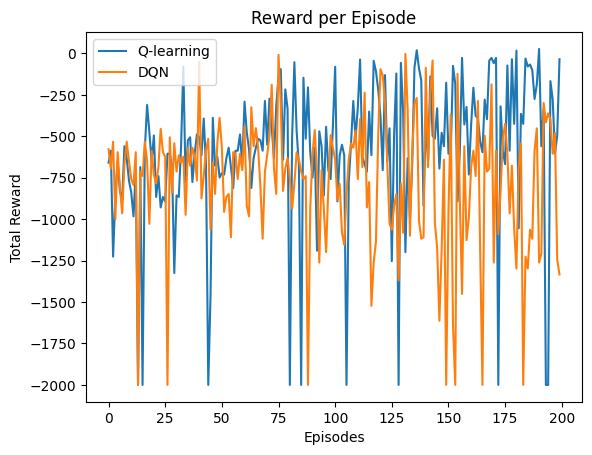


Q-learning path:
S A X . . . . . X .
. . . . . . . . X .
. . . X X X . . . X
X . . . X . . X . .
. . . X . . . . . X
. X . . . . X . . .
. . X . . . . . . .
. . . . . . . . . .
. X . . . . X X X X
. . . . . . . . . G



DQN path:
A X X . . X . . . X
X . . . . X . X . .
. . X X . . . . . .
. . X . . . . X . .
. . . X . . . X . .
. . . . . . . . X .
. . . . . . . . . .
. . . . . . X . . X
. X . . . . . . . .
X . X . X . . . . G




In [8]:
# Plotting Rewards
plt.plot(rewards_q, label='Q-learning')
plt.plot(rewards_dqn, label='DQN')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.legend()
plt.show()

print("\nQ-learning path:")
env1.render(path_q)

print("\nDQN path:")
env2.render(path_dqn)

### Comparative Performance Summary

| Metric               | Q-Learning          | DQN                     |
|----------------------|---------------------|--------------------------|
| Convergence Speed    | Faster              | Slower (initially)      |
| Final Path Efficiency| Good                | Very Good               |
| Generalization       | Limited             | Better due to NN        |
| Memory Efficiency    | High                | Lower (needs GPU/CPU)   |
| Scalability          | Poor (large state)  | Excellent               |
